<a href="https://colab.research.google.com/github/ahzaidy/Programs/blob/main/CPSC_5410_HW1_P4_BO_LCB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

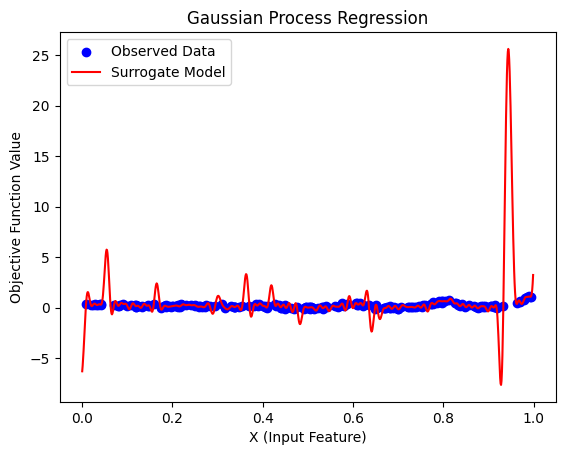

>x=0.930, f()=-6.632, actual=0.077
>x=0.942, f()=-11.077, actual=0.400
>x=0.484, f()=-1.557, actual=0.091
>x=0.923, f()=-0.997, actual=0.119
>x=0.959, f()=-1.915, actual=0.373
>x=0.005, f()=-2.125, actual=0.085
>x=0.645, f()=-1.449, actual=0.331
>x=0.548, f()=-0.449, actual=0.116
>x=0.066, f()=-0.577, actual=0.353
>x=0.659, f()=-2.209, actual=0.058
>x=0.947, f()=-0.719, actual=-0.042
>x=0.320, f()=-0.145, actual=-0.034
>x=0.289, f()=-0.670, actual=0.192
>x=0.375, f()=-0.845, actual=0.138
>x=0.361, f()=-1.930, actual=0.058
>x=0.156, f()=-0.295, actual=0.187
>x=0.516, f()=-0.238, actual=0.031
>x=0.767, f()=-0.305, actual=0.373
>x=0.466, f()=-0.178, actual=-0.043
>x=0.475, f()=-0.040, actual=0.087
>x=0.467, f()=-0.090, actual=0.040
>x=0.582, f()=-0.206, actual=0.339
>x=0.489, f()=-0.137, actual=0.023
>x=0.600, f()=-2.177, actual=0.422
>x=0.686, f()=-0.071, actual=-0.010
>x=0.700, f()=-0.155, actual=0.001
>x=0.631, f()=-0.216, actual=0.156
>x=0.595, f()=-0.185, actual=0.210
>x=0.174, f()=-

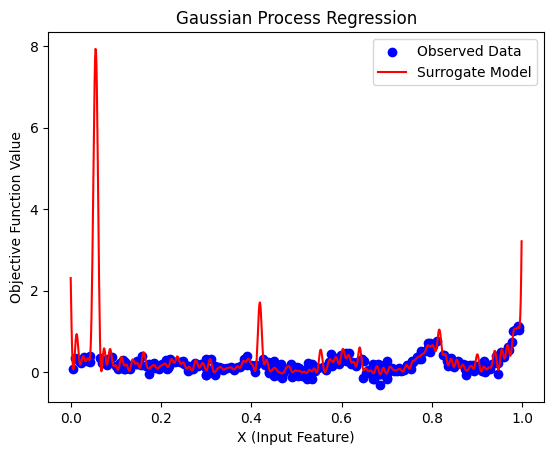

Best Result: x=0.686, y=-0.310


In [2]:
# Import necessary libraries
from math import sin, cos, pi  # Import trigonometric functions and constant pi
from numpy import arange, vstack, argmin, argmax, asarray  # Import NumPy functions for array operations
from numpy.random import normal, random  # Import random sampling functions
from scipy.stats import norm  # Import normal distribution functions
from sklearn.gaussian_process import GaussianProcessRegressor  # Import Gaussian Process Regressor from scikit-learn
from sklearn.gaussian_process.kernels import RBF  # Import Radial Basis Function (RBF) kernel
from warnings import catch_warnings, simplefilter  # Import warning handling utilities
from matplotlib import pyplot  # Import plotting library
import warnings

# Suppress all warnings for cleaner output
warnings.filterwarnings("ignore")

# Define the objective function to be optimized
def objective(x, noise=0.1):
    """
    Computes the function value with added Gaussian noise.
    The function consists of a quadratic and cosine-based term.

    :param x: Input value
    :param noise: Standard deviation of noise to be added
    :return: Function value with noise
    """
    noise = normal(loc=0, scale=noise)  # Generate Gaussian noise
    return ((x - 0.6) ** 2 + x ** 2 * cos(5 * pi * x) ** 6.0) + noise  # Compute function value with noise

# Define the surrogate function used in Bayesian optimization
def surrogate(model, X):
    """
    Predicts the mean and standard deviation using the Gaussian Process model.

    :param model: Trained Gaussian Process Regressor
    :param X: Input values for prediction
    :return: Tuple of mean predictions and standard deviations
    """
    with catch_warnings():
        simplefilter("ignore")  # Suppress warnings from the model
        return model.predict(X, return_std=True)  # Get mean and standard deviation

# Define the acquisition function using the Lower Confidence Bound (LCB) method
def acquisition(X, Xsamples, model, kappa=1.96):
    """
    Computes the Lower Confidence Bound (LCB) acquisition score.

    :param X: Observed input data
    :param Xsamples: Candidate points for evaluation
    :param model: Trained Gaussian Process model
    :param kappa: Exploration-exploitation tradeoff parameter (higher kappa = more exploration)
    :return: LCB scores for all samples
    """
    # Compute the best observed mean prediction
    yhat, _ = surrogate(model, X)
    best = max(yhat)

    # Compute the mean and standard deviation for candidate samples
    mu, std = surrogate(model, Xsamples)

    # Compute the LCB score (lower is better)
    scores = mu - kappa * std
    return scores

# Function to find the next best sample to evaluate
def opt_acquisition(X, y, model):
    """
    Optimizes the acquisition function to find the next sample to evaluate.

    :param X: Observed input data
    :param y: Observed target values
    :param model: Trained Gaussian Process model
    :return: Next input value to sample
    """
    # Generate 100 random sample points in the range [0,1]
    Xsamples = random(100).reshape(-1, 1)

    # Compute acquisition scores for all sample points
    scores = acquisition(X, Xsamples, model)

    # Select the sample with the lowest acquisition score
    ix = argmin(scores)
    return Xsamples[ix, 0]


# Function to plot real observations vs surrogate function
def plot(X, y, model, img_name='plot'):
    # Scatter plot of actual sampled points
    pyplot.scatter(X, y, label="Observed Data", color="blue")

    # Generate input samples for plotting the surrogate model
    Xsamples = asarray(arange(0, 1, 0.001)).reshape(-1, 1)
    ysamples, _ = surrogate(model, Xsamples)

    # Plot the Gaussian Process (Surrogate Model)
    pyplot.plot(Xsamples, ysamples, label="Surrogate Model", color="red")

    # Add confidence interval shading (optional)
    # Uncomment below if needed
    # _, sigma = surrogate(model, Xsamples)
    # pyplot.fill_between(Xsamples.ravel(), ysamples - 1.96 * sigma, ysamples + 1.96 * sigma, color='gray', alpha=0.2)

    # **Add X and Y axis labels**
    pyplot.xlabel("X (Input Feature)")  # Label for X-axis
    pyplot.ylabel("Objective Function Value")  # Label for Y-axis

    # Add a title for clarity
    pyplot.title("Gaussian Process Regression")

    # Add legend for better interpretation
    pyplot.legend()

    # Display the plot
    pyplot.show()

    # Close the figure to free memory
    pyplot.close()


# Generate 200 random sample points in the range [0,1]
X = random(200)

# Evaluate the objective function at each sample point
y = asarray([objective(x) for x in X])

# Reshape the data to be in column vector form
X = X.reshape(-1, 1)
y = y.reshape(-1, 1)

# Define the Gaussian Process model using an RBF kernel
kernel = RBF(length_scale=0.1, length_scale_bounds=(1e-2, 10.0))
model = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, n_restarts_optimizer=2)

# Train the model using the initial dataset
model.fit(X, y)

# Plot the initial state of the model before optimization
plot(X, y, model, img_name='gp_initial_model')

# Perform the Bayesian Optimization process for 100 iterations
for i in range(100):
    # Find the next best sample point to evaluate
    x = opt_acquisition(X, y, model)

    # Evaluate the actual function value at the selected point
    actual = objective(x)

    # Get the model's prediction for the selected point
    est, _ = surrogate(model, [[x]])

    # Print the predicted and actual values
    print('>x=%.3f, f()=%.3f, actual=%.3f' % (x, est[0], actual))

    # Add the new sample point to the dataset
    X = vstack((X, [[x]]))
    y = vstack((y, [[actual]]))

    # Update the Gaussian Process model with the new data
    model.fit(X, y)

# Plot the final optimized model
plot(X, y, model, img_name='gp_result_model')

# Find and print the best result found during optimization
ix = argmin(y)
print('Best Result: x=%.3f, y=%.3f' % (X[ix].item(), y[ix].item()))